In [22]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dsets 
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

#hyperparameters
batchsize=64 #batch-size of 64
imgsize=64 #image of size (64,64)

#creating transformations so that the image is ready to be fed to the neural network
transform=transforms.Compose([transforms.Resize(imgsize),transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]) # Applying transformation(resizing,tensor conversion and normalization) to the image  

#loading the dataset
dataset=dsets.ImageFolder(root='mydata',transform=transform)
dataloader=torch.utils.data.DataLoader(dataset,batch_size=batchsize,shuffle=True,num_workers=3) #Dataloader helps is to load data in specific batch size and whether we want to shuffle it or not and num_workers=-1 means it uses all the parallel processes available

print('Dataloader executed')
#GANs use a different type of weight initialization called Xavier's Initialization
def weights(network):
	classname=network.__class__.__name__ # this line searches for the name of the class in the network defination
	if classname.find('Conv') !=-1: #this line finds the occurance of the strin g 'Conv' in the network function's defination and if the string 'Conv' is present then it activates the if loop
		with torch.no_grad():
			network.weight.normal_(0.0,0.02)
	elif classname.find('BatchNorm')!=-1: #similar operation as above
		with torch.no_grad():
			network.weight.data.normal_(1.0,0.02)
		# network.bias.data.fill_(0)
# Defining the generator network

class generator(nn.Module):
	def __init__(self):
		super(generator,self).__init__() # this line passes all the goodness of nn.module in the generator class that we defined 
		self.main=nn.Sequential(nn.ConvTranspose2d(100,512,4,1,0,bias=False), #100 is the input noise vector, 512 are the new feature maps,4 is the size of kernel(4,4),1 is the stride of the kernel,0 is the padding and bias is set to false
			nn.ReLU(True), #to introduce non-linearity
			nn.BatchNorm2d(512), #normalizing all the new feature maps
			nn.ConvTranspose2d(512,256,4,2,1,bias=False),
			nn.ReLU(True),
			nn.BatchNorm2d(256),
			nn.ConvTranspose2d(256,128,4,2,1,bias=False),
			nn.ReLU(True),
			nn.BatchNorm2d(128),
			nn.ConvTranspose2d(128,64,4,2,1,bias=False),
			nn.ReLU(True),
			nn.BatchNorm2d(64),
			nn.ConvTranspose2d(64,3,4,2,1,bias=False),
			nn.Tanh() #Tanh is selected here because the dataset has values between -1 and 1 , also Tanh is bounded, this bounded and symmetrical nature of the function helps the model to learn faster 
			)
	def forward(self,x):
		output=self.main(x)
		return output
netG=generator()
netG.cuda()
netG.apply(weights) #applying weights initizlization function on the generator function


class discriminator(nn.Module):
	def __init__(self):
		super(discriminator,self).__init__() #to activate inheritance
		self.main=nn.Sequential(
			nn.Conv2d(3,64,4,2,1,bias=False),
			nn.LeakyReLU(0.02,inplace=True),
			nn.Conv2d(64,128,4,2,1,bias=False),
			nn.BatchNorm2d(128),
			nn.LeakyReLU(0.02,inplace=True),
			nn.Conv2d(128,256,4,2,1,bias=False),
			nn.BatchNorm2d(256),
			nn.LeakyReLU(0.02,inplace=True),
			nn.Conv2d(256,512,4,2,1,bias=False),
			nn.BatchNorm2d(512),
			nn.LeakyReLU(0.02,inplace=True),
			nn.Conv2d(512,1,4,1,0,bias=False),
			nn.Sigmoid()			
			)
	def forward(self,x):
		output=self.main(x)
		return output.view(-1) # .view(-1) is used to reshape the convouled image and flatten it along a single axis.

print('Networks defined')
netD=discriminator()
netD.cuda()
netD.apply(weights) #applying weights initizlization function on the generator function

run=75
###### TRAINING THE GANs ########
criterion = nn.BCELoss()
optimizerD=optim.Adam(netD.parameters(),lr=0.001,betas=(0.5,0.999)) #the value of betas is selected from experimentation
optimizerG=optim.Adam(netG.parameters(),lr=0.001,betas=(0.5,0.999))
err_dis=[]
err_gen=[]
print('Loop starting now')
for epoch in range(run):	
	for i,data in enumerate(dataloader,0): #0 in the enumerate parenthesis is just the starting value we want 'i' to take.
		netD.zero_grad() #clearing gradient buffers and setting it to zero for every new batch



		###Training the discriminator network on real images

		images,_=data #_ here holds the labels of the images. As we dont want the labels here we just throw it away
		real=Variable(images.cuda()) #to compute gradients, we need to wrap the image with a Variable class
		real_targets=Variable(torch.ones(real.size()[0]).cuda()) #setting real tagerts to 1s and deciding the size on basis of how many images are present in real variable
		output=netD(real) #computing the outputs through discriminator which will be a number between 0 and 1 giving probablity of image being real or fake
		error_real=criterion(output,real_targets) #calculating the error for real images and their output given by our discriminator network

		###Training the images on fake network
		noise=Variable(torch.randn(real.size()[0],100,1,1).cuda()) #this line can be interpreted like a matrix which has real.size()[0] number of rows and 100 number of columns(technically feature maps) and each column has a 1x1 array
		fake_output=netG(noise)  #generator uses this noise vector to generate a mini-batch of fakeimages
		fake_target=Variable(torch.zeros(real.size()[0]).cuda())#instantiating the fake target as 0s
		output=netD(fake_output.detach()) #the fake_output is a torch variable and it contains the data as well as the gradients, but we dont want this gradients so we will only use the data and for that we use .detach() method
		error_fake=criterion(output,fake_target) #calculating the error of fake images with wrt their output

		error_total=error_real+error_fake
		error_total.backward() #this line back-propagates the error 
		optimizerD.step()      #this line updates the parameters of netD

		##Training the generator
		netG.zero_grad() #initializing the gradients of generaotr neural net
		output=netD(fake_output) #notice here we didnt use .detach() because we want to update the weights of generator unlike previously where we were updating the weights of discriminator, because the fake_output is generated by generator and not discriminator
		target=Variable(torch.ones(real.size()[0]).cuda()) #here we defined targets as 1s because we want the generator to generate near perfect images which the discriminator should predict as real( or target =1) 
		error_gen=criterion(output,target)
		error_gen.backward()
		optimizerG.step()
		print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f' % (epoch, run, i, len(dataloader), error_total.data, error_gen.data))
		if i%10000==0:
			vutils.save_image(real, '%s/real_samples.png' % "./results", normalize = True)
			fake = netG(noise)
			vutils.save_image(fake.data, '%s/fake_samples_epoch_%03d.png' % ("./results", epoch), normalize = True)
	err_dis.append(torch.sum(error_total))
	err_gen.append(torch.sum(error_gen))

print('Training Completed')

Dataloader executed
Networks defined
Loop starting now
[0/75][0/2] Loss_D: 1.9494 Loss_G: 5.7653
[0/75][1/2] Loss_D: 1.5667 Loss_G: 21.2722
[1/75][0/2] Loss_D: 0.0000 Loss_G: 21.1985
[1/75][1/2] Loss_D: 0.1045 Loss_G: 18.1663
[2/75][0/2] Loss_D: 0.0018 Loss_G: 10.8344
[2/75][1/2] Loss_D: 1.9049 Loss_G: 28.5911
[3/75][0/2] Loss_D: 1.8375 Loss_G: 24.7300
[3/75][1/2] Loss_D: 0.0000 Loss_G: 18.8437
[4/75][0/2] Loss_D: 0.0297 Loss_G: 10.5248
[4/75][1/2] Loss_D: 5.3280 Loss_G: 31.8827
[5/75][0/2] Loss_D: 29.5119 Loss_G: 27.2819
[5/75][1/2] Loss_D: 9.9463 Loss_G: 15.2354
[6/75][0/2] Loss_D: 0.0005 Loss_G: 7.4452
[6/75][1/2] Loss_D: 2.7934 Loss_G: 16.1866
[7/75][0/2] Loss_D: 0.4147 Loss_G: 15.6007
[7/75][1/2] Loss_D: 0.0015 Loss_G: 14.9349
[8/75][0/2] Loss_D: 0.0270 Loss_G: 11.4063
[8/75][1/2] Loss_D: 0.1223 Loss_G: 7.7063
[9/75][0/2] Loss_D: 0.0731 Loss_G: 8.1336
[9/75][1/2] Loss_D: 0.0680 Loss_G: 9.2292
[10/75][0/2] Loss_D: 0.0105 Loss_G: 9.3465
[10/75][1/2] Loss_D: 0.0278 Loss_G: 8.5770
[11

Text(0, 0.5, 'Loss')

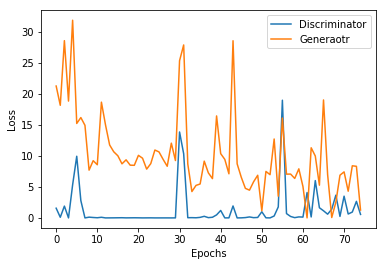

In [24]:
plt.plot(range(run),err_dis,label='Discriminator')
plt.plot(range(run),err_gen,label='Generaotr')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')